# EDA - Receitas

Este notebook contém a análise exploratória dos dados de receitas culinárias fornecidos no desafio da Oncase. O objetivo é compreender a estrutura dos dados, identificar padrões, e extrair insights relevantes para modelagens futuras e sistemas de recomendação.

---
## 1. Carregamento dos dados


In [103]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os

from collections import Counter
from itertools import chain


# Estilo de gráficos
plt.style.use("seaborn-v0_8-whitegrid")
sns.set_palette("Set2")


with open('../receitas.json', 'r', encoding='utf-8') as f:
    receitas = json.load(f)

print(type(receitas))


<class 'list'>


## 2. Estrutura inicial dos dados


In [104]:
# Transformando a lista de dicionários em DataFrame
df_receitas = pd.DataFrame(receitas)

# Visualização inicial
df_receitas.head()

,directions,fat,date,categories,calories,desc,protein,rating,title,ingredients,sodium
0,"[1. Place the stock, lentils, celery, carrot, ...",7.0,2006-09-01T04:00:00.000Z,"[Sandwich, Bean, Fruit, Tomato, turkey, Vegeta...",426.0,None,30.0,2.500,"Lentil, Apple, and Turkey Wrap","[4 cups low-sodium vegetable or chicken stock,...",559.0
1,[Combine first 9 ingredients in heavy medium s...,23.0,2004-08-20T04:00:00.000Z,"[Food Processor, Onion, Pork, Bake, Bastille D...",403.0,This uses the same ingredients found in boudin...,18.0,4.375,Boudin Blanc Terrine with Red Onion Confit,"[1 1/2 cups whipping cream, 2 medium onions, c...",1439.0
2,[In a large heavy saucepan cook diced fennel a...,7.0,2004-08-20T04:00:00.000Z,"[Soup/Stew, Dairy, Potato, Vegetable, Fennel, ...",165.0,None,6.0,3.750,Potato and Fennel Soup Hodge,"[1 fennel bulb (sometimes called anise), stalk...",165.0
3,[Heat oil in heavy large skillet over medium-h...,NaN,2009-03-27T04:00:00.000Z,"[Fish, Olive, Tomato, Sauté, Low Fat, Low Cal,...",NaN,The Sicilian-style tomato sauce has tons of Me...,NaN,5.000,Mahi-Mahi in Tomato Olive Sauce,"[2 tablespoons extra-virgin olive oil, 1 cup c...",NaN
4,[Preheat oven to 350°F. Lightly grease 8x8x2-i...,32.0,2004-08-20T04:00:00.000Z,"[Cheese, Dairy, Pasta, Vegetable, Side, Bake, ...",547.0,None,20.0,3.125,Spinach Noodle Casserole,"[1 12-ounce package frozen spinach soufflé, th...",452.0


## 3. Dimensão e tipos de dados


In [105]:
print("Shape:", df_receitas.shape)
print("\nColunas:", df_receitas.columns.tolist())
print("\nTipos de dados:\n", df_receitas.dtypes)

Shape: (20130, 11)

Colunas: ['directions', 'fat', 'date', 'categories', 'calories', 'desc', 'protein', 'rating', 'title', 'ingredients', 'sodium']

Tipos de dados:
 directions      object
fat            float64
date            object
categories      object
calories       float64
desc            object
protein        float64
rating         float64
title           object
ingredients     object
sodium         float64
dtype: object


### 3.1 Pré-tratamento geral


In [106]:
# Converter a coluna 'date' para datetime
df_receitas['date'] = pd.to_datetime(df_receitas['date'], errors='coerce')

# Remover espaços em branco nas colunas textuais
df_receitas['title'] = df_receitas['title'].str.strip()
df_receitas['desc'] = df_receitas['desc'].str.strip()

# Garantir que colunas do tipo lista estejam consistentes
for col in ['categories', 'ingredients', 'directions']:
    df_receitas[col] = df_receitas[col].apply(lambda x: x if isinstance(x, list) else [])

# Criar features de contagem
df_receitas['n_ingredients'] = df_receitas['ingredients'].apply(len)
df_receitas['n_categories'] = df_receitas['categories'].apply(len)
df_receitas['n_directions'] = df_receitas['directions'].apply(len)


In [107]:
# Visualizar rapidamente as novas colunas
df_receitas[['n_ingredients', 'n_categories', 'n_directions']].describe()

# Checar se ainda há valores inesperados
df_receitas[['categories', 'ingredients', 'directions']].applymap(type).sample(3)


/var/folders/3f/by58trlj5m7185rxyjvklyg00000gn/T/ipykernel_9257/2257851059.py:5: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.



,categories,ingredients,directions
1955,<class 'list'>,<class 'list'>,<class 'list'>
9246,<class 'list'>,<class 'list'>,<class 'list'>
7245,<class 'list'>,<class 'list'>,<class 'list'>


## 4. Análise de dados ausentes

In [108]:
# Quantidade absoluta e percentual de valores ausentes por coluna
missing_abs = df_receitas.isnull().sum()
missing_pct = (df_receitas.isnull().mean() * 100).round(2)

missing_df = pd.DataFrame({
    'Ausentes': missing_abs,
    '%': missing_pct
}).sort_values(by='Ausentes', ascending=False)

missing_df


,Ausentes,%
desc,6635,32.96
fat,4222,20.97
protein,4201,20.87
sodium,4156,20.65
calories,4154,20.64
rating,30,0.15
date,19,0.09
title,19,0.09
directions,0,0.00
categories,0,0.00


- As colunas `fat`, `calories`, `protein`, `sodium` e `desc` têm volumes significativos de nulos.
- Ainda não serão tratados, pois dependem do objetivo da análise/modelo a ser feito.
- Futuramente: considerar imputação (ex: média, mediana) ou exclusão seletiva.

## 5. Análise de colunas categóricas em formato de lista

As colunas `categories` e `ingredients` armazenam informações em listas. Vamos explorar:

- Quantas categorias/tags cada receita possui?
- Quais são as categorias mais frequentes?
- Quantos ingredientes são usados por receita?
- Quais os ingredientes mais comuns no dataset?


### 5.1 Distribuição de categorias e ingredientes por receita


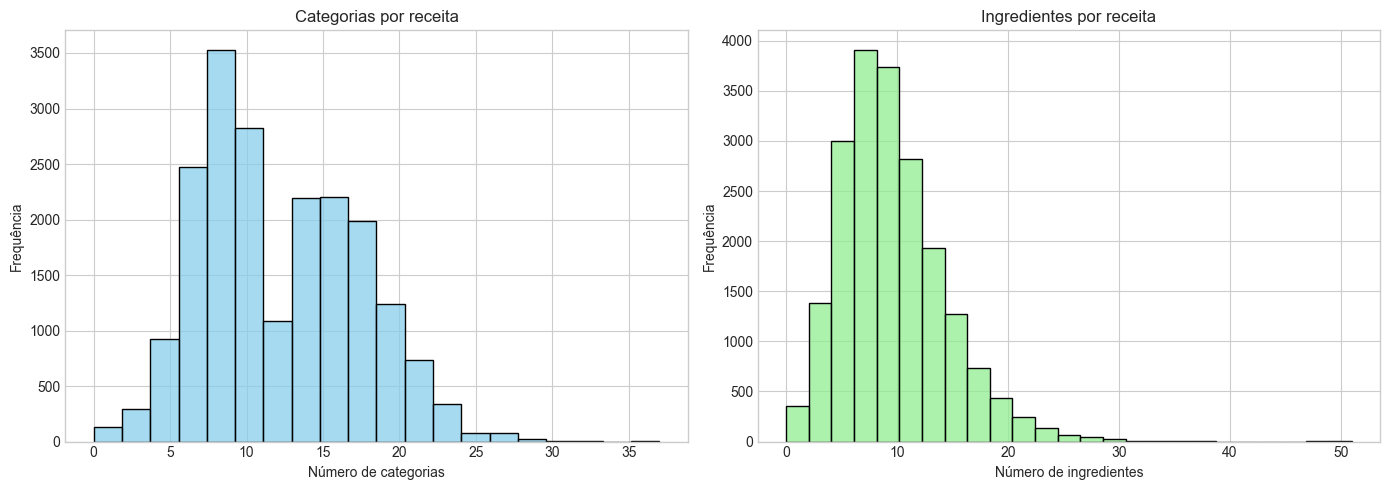

In [109]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.histplot(df_receitas['n_categories'], bins=20, ax=axes[0], color='skyblue')
axes[0].set_title('Categorias por receita')
axes[0].set_xlabel('Número de categorias')
axes[0].set_ylabel('Frequência')

sns.histplot(df_receitas['n_ingredients'], bins=25, ax=axes[1], color='lightgreen')
axes[1].set_title('Ingredientes por receita')
axes[1].set_xlabel('Número de ingredientes')
axes[1].set_ylabel('Frequência')

plt.tight_layout()
plt.show()


> A maioria das receitas possui entre 5 e 15 categorias associadas, com pico em torno de 8 categorias. Algumas receitas possuem mais de 25 categorias, o que pode indicar ruído ou excesso de marcações genéricas.


> O número de ingredientes por receita segue uma distribuição semelhante à normal, centrada entre 8 e 12 ingredientes. Receitas com mais de 25 ingredientes são incomuns e podem indicar pratos complexos ou segmentações redundantes de itens.





### 5.2 Categorias mais frequentes


/var/folders/3f/by58trlj5m7185rxyjvklyg00000gn/T/ipykernel_9257/2420559042.py:9: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




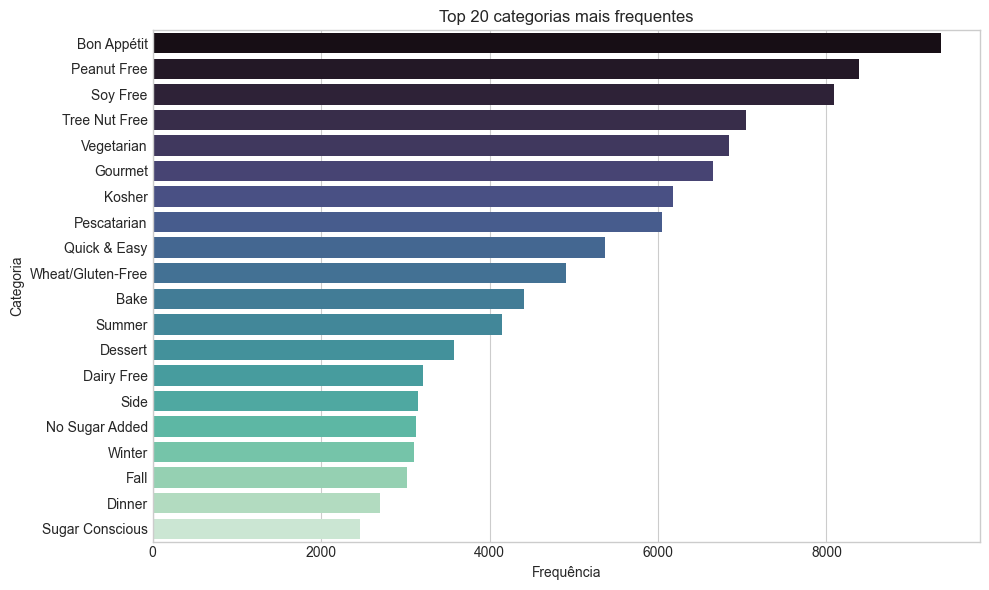

In [110]:
# Explode a lista de categorias e conta frequência
all_categories = [cat for sublist in df_receitas['categories'] for cat in sublist]
top_cats = Counter(all_categories).most_common(20)

# Transforma em DataFrame para plotar
df_top_cats = pd.DataFrame(top_cats, columns=['Categoria', 'Frequência'])

plt.figure(figsize=(10,6))
sns.barplot(data=df_top_cats, y='Categoria', x='Frequência', palette='mako')
plt.title('Top 20 categorias mais frequentes')
plt.xlabel('Frequência')
plt.ylabel('Categoria')
plt.tight_layout()
plt.show()


> As categorias mais frequentes estão ligadas a preferências alimentares e filtros de saúde, como "Peanut Free", "Vegetarian", "Kosher" e "Gourmet". Isso sugere que o dataset está bem estruturado para personalizações com base em restrições alimentares.


### 5.3 Ingredientes mais comuns


/var/folders/3f/by58trlj5m7185rxyjvklyg00000gn/T/ipykernel_9257/3295114452.py:8: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




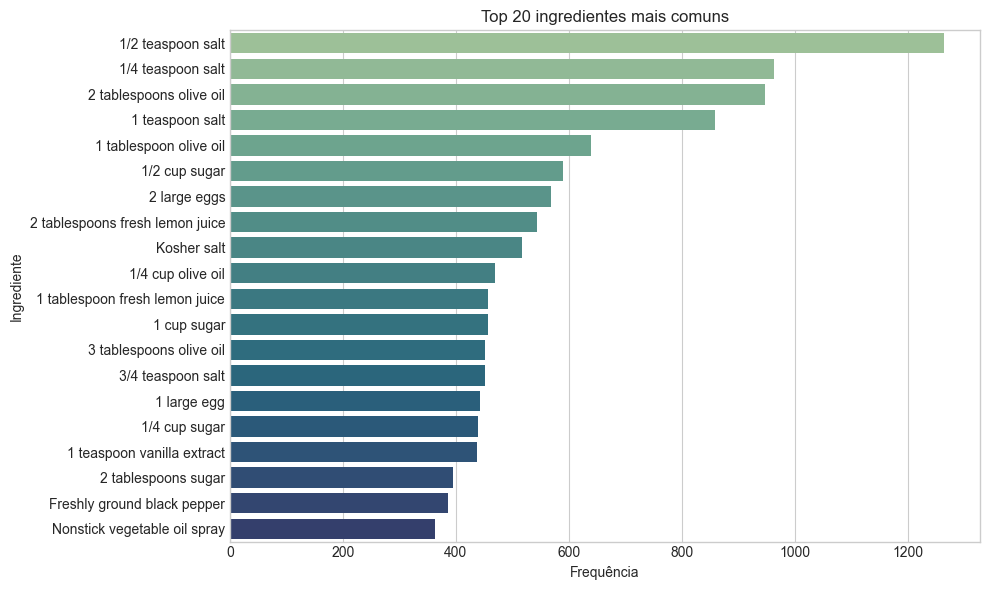

In [111]:
# Explode a lista de ingredientes
all_ingredientes = [ing for sublist in df_receitas['ingredients'] for ing in sublist]
top_ingredientes = Counter(all_ingredientes).most_common(20)

df_top_ings = pd.DataFrame(top_ingredientes, columns=['Ingrediente', 'Frequência'])

plt.figure(figsize=(10,6))
sns.barplot(data=df_top_ings, y='Ingrediente', x='Frequência', palette='crest')
plt.title('Top 20 ingredientes mais comuns')
plt.xlabel('Frequência')
plt.ylabel('Ingrediente')
plt.tight_layout()
plt.show()


> Ingredientes mais comuns envolvem sal, açúcar, azeite e ovos — ingredientes básicos e coringas em receitas. O domínio do sal em diferentes medidas sugere possível oportunidade para normalização de nomenclaturas futuras.


## 6. Análise das variáveis numéricas


### 6.1 Distribuição das variáveis nutricionais e avaliação


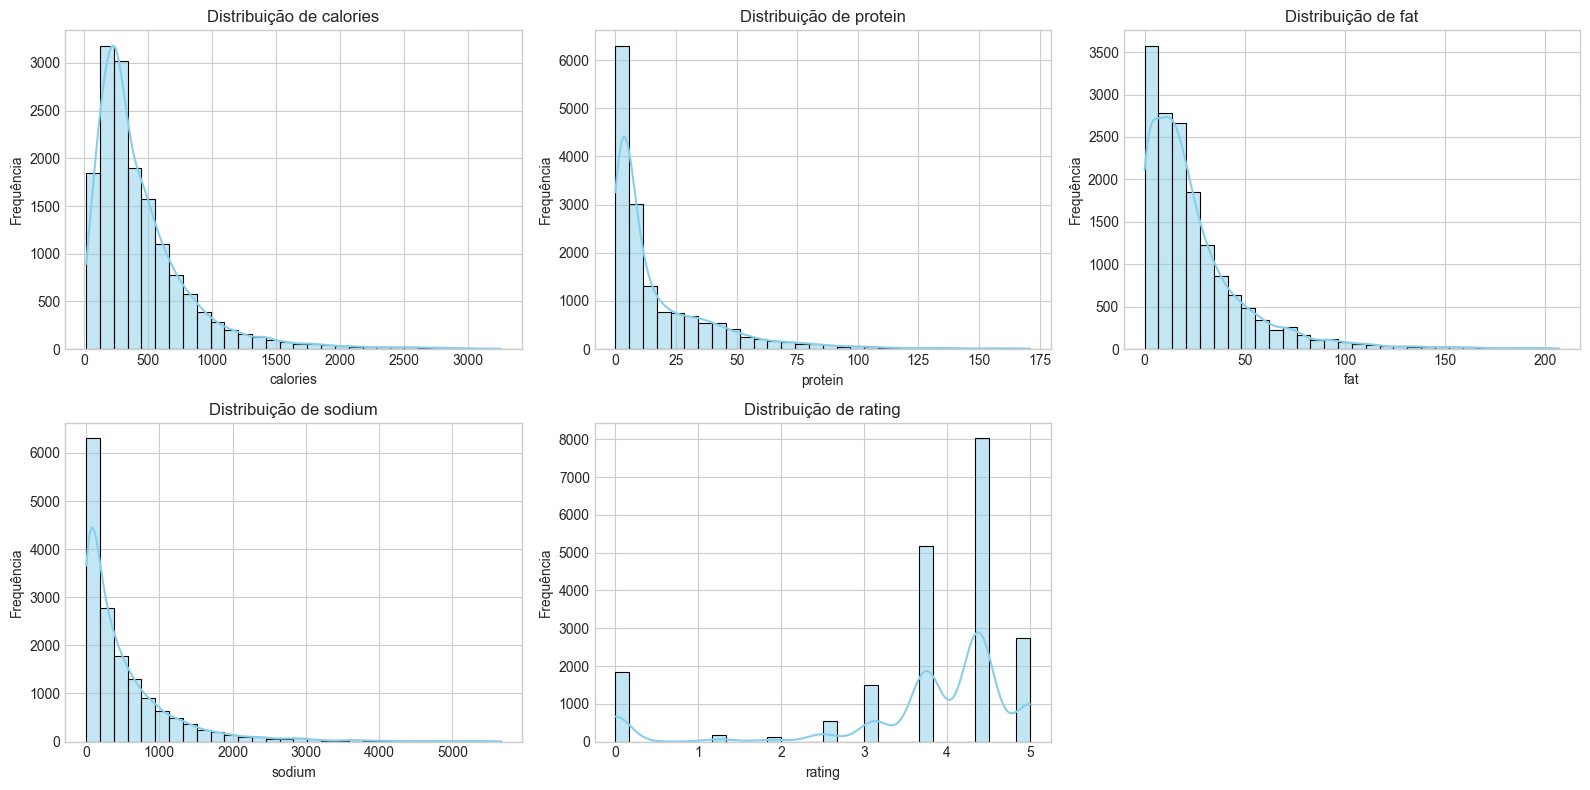

In [112]:
cols_numericas = ['calories', 'protein', 'fat', 'sodium', 'rating']

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(16, 8))
axes = axes.flatten()

for i, col in enumerate(cols_numericas):
    data = df_receitas[col].dropna()
    
    # Definindo limites entre 1º e 99º percentil
    lower = data.quantile(0.01)
    upper = data.quantile(0.99)
    
    # Filtrando os dados
    filtered_data = data[(data >= lower) & (data <= upper)]
    
    sns.histplot(filtered_data, bins=30, kde=True, ax=axes[i], color='skyblue')
    axes[i].set_title(f'Distribuição de {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequência')

# Esconde o último gráfico (caso sobre espaço)
axes[-1].axis('off')

plt.tight_layout()
plt.show()

### Distribuições das Variáveis Numéricas (sem outliers)

- **Calories**: Distribuição assimétrica, concentrada abaixo de 500. Há uma cauda longa para valores maiores.
- **Protein**: Valores baixos são mais comuns. Assimetria à direita, com poucos casos acima de 50g.
- **Fat**: Parecida com calories — maioria abaixo de 30g, com poucos casos extremos.
- **Sodium**: Altamente concentrada até 1000mg. Muitos outliers removidos acima de 2000mg.
- **Rating**: Distribuição irregular. Picos em notas como 3.0, 4.0 e 5.0 indicam preferência dos usuários por valores altos.



### 6.2 Correlação entre variáveis numéricas


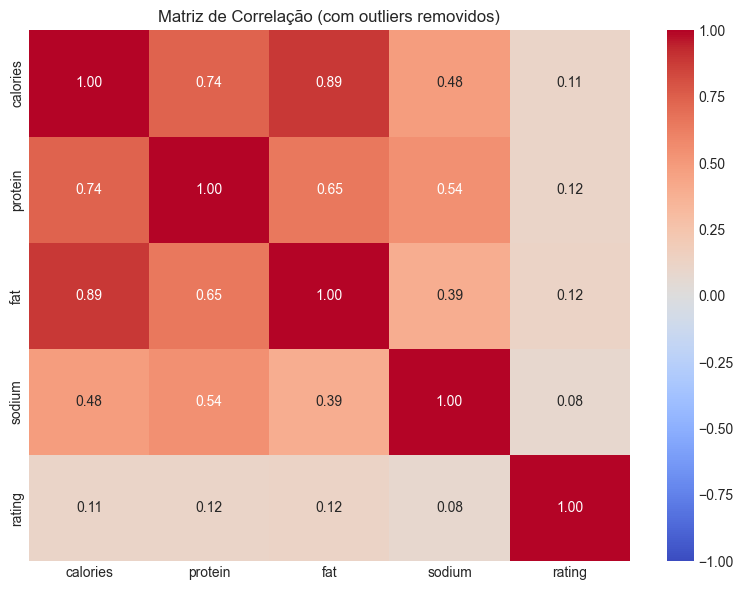

In [130]:
# Selecionando os dados numéricos com outliers tratados
df_filtrado = pd.DataFrame()

for col in cols_numericas:
    data = df_receitas[col].dropna()
    lower = data.quantile(0.01)
    upper = data.quantile(0.99)
    df_filtrado[col] = data[(data >= lower) & (data <= upper)]

# Calculando a matriz de correlação
corr_matrix = df_filtrado.corr()

# Plotando o heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
plt.title('Matriz de Correlação (com outliers removidos)')
plt.tight_layout()
plt.show()

###  Correlação (com outliers removidos)

- **Alta correlação entre calorias e gordura (0.89)**, e também com proteína (0.74), o que faz sentido nutricionalmente.
- **Rating tem correlação fraca com as demais variáveis** (máximo ~0.12), sugerindo que os fatores nutricionais não influenciam diretamente a nota dada.


### 7. Relação entre variáveis numéricas e rating

Vamos investigar como as variáveis nutricionais influenciam a avaliação (`rating`) das receitas. Usaremos boxplots e scatterplots para identificar padrões, tendências e possíveis variáveis preditoras.


/var/folders/3f/by58trlj5m7185rxyjvklyg00000gn/T/ipykernel_9257/1072514407.py:12: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/var/folders/3f/by58trlj5m7185rxyjvklyg00000gn/T/ipykernel_9257/1072514407.py:15: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/var/folders/3f/by58trlj5m7185rxyjvklyg00000gn/T/ipykernel_9257/1072514407.py:18: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/var/folders/3f/by58trlj5m7185rxyjvklyg00000gn/T/ipykernel_9257/1072514407.py:21: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the 

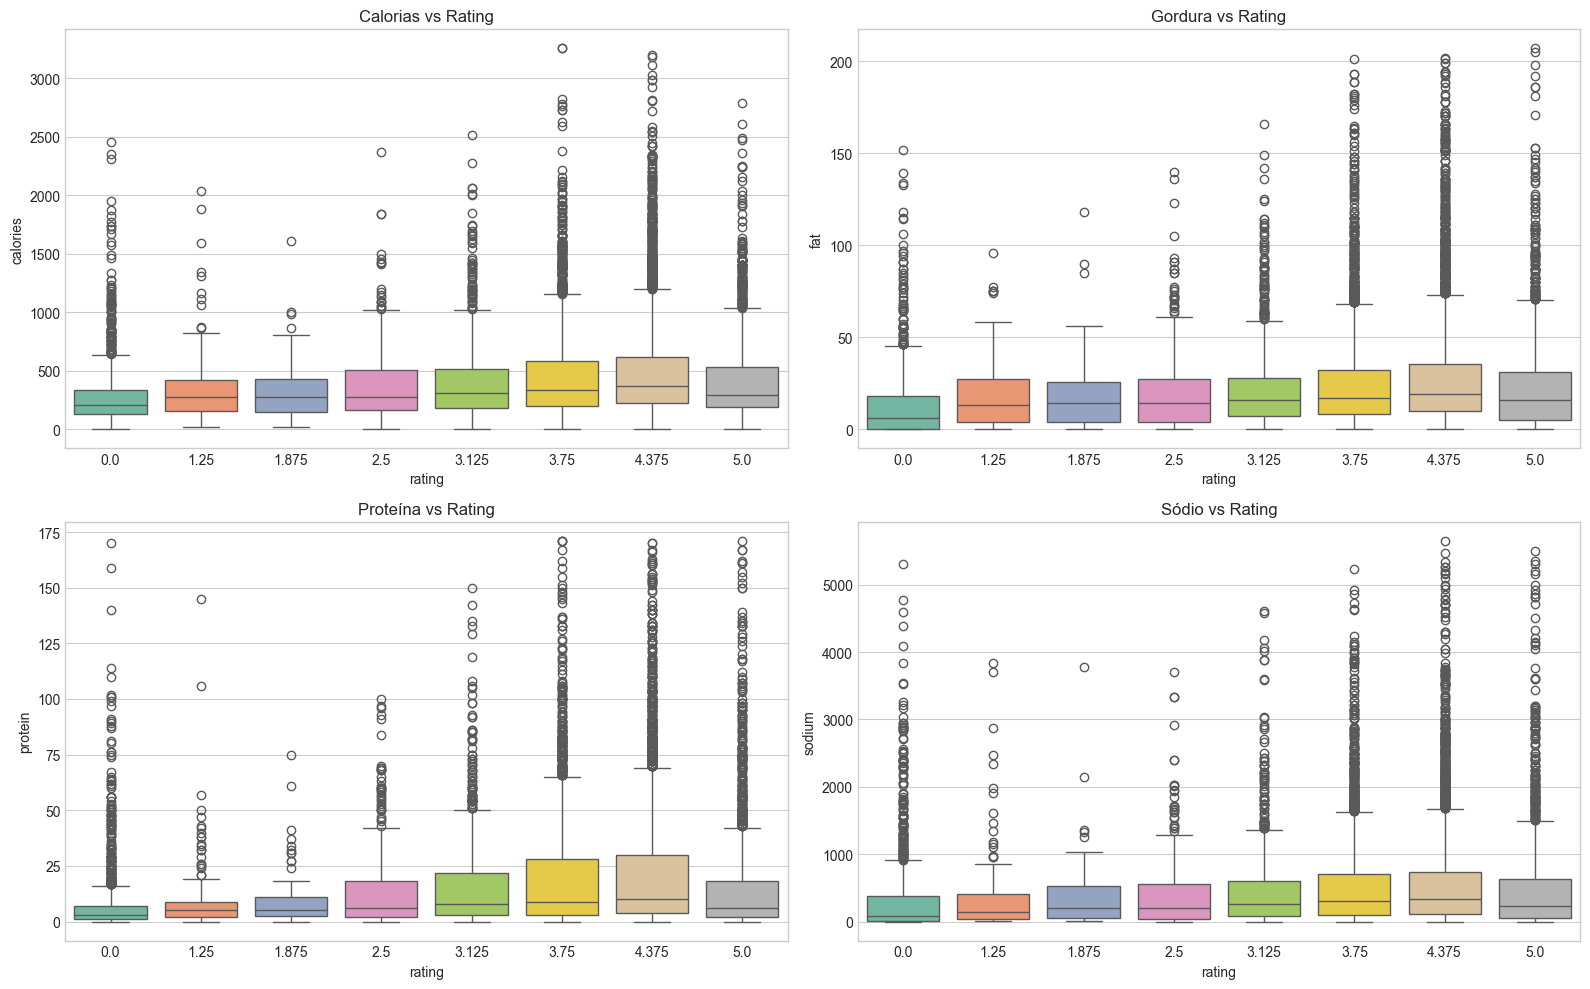

In [114]:
# Removendo outliers extremos com base no percentil 99
num_cols = ['calories', 'fat', 'protein', 'sodium']
df_limpo = df_receitas.copy()

for col in num_cols:
    limite = df_receitas[col].quantile(0.99)
    df_limpo = df_limpo[df_limpo[col] <= limite]

# Plot atualizado
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

sns.boxplot(x='rating', y='calories', data=df_limpo, ax=axes[0, 0], palette='Set2')
axes[0, 0].set_title('Calorias vs Rating')

sns.boxplot(x='rating', y='fat', data=df_limpo, ax=axes[0, 1], palette='Set2')
axes[0, 1].set_title('Gordura vs Rating')

sns.boxplot(x='rating', y='protein', data=df_limpo, ax=axes[1, 0], palette='Set2')
axes[1, 0].set_title('Proteína vs Rating')

sns.boxplot(x='rating', y='sodium', data=df_limpo, ax=axes[1, 1], palette='Set2')
axes[1, 1].set_title('Sódio vs Rating')

plt.tight_layout()
plt.show()


### Relação entre variáveis nutricionais e rating

Os boxplots filtrados (com outliers extremos removidos) permitem avaliar como as variáveis nutricionais se comportam em diferentes faixas de avaliação (rating):

- **Calorias:** receitas com rating mais alto tendem a ter maior valor calórico, com aumento moderado na mediana a partir do rating 3.
- **Gordura e proteína:** seguem padrão semelhante ao das calorias, com distribuição ascendente de valores conforme o rating aumenta.
- **Sódio:** apresenta maior variabilidade, mas também há tendência de elevação nas receitas com melhores avaliações.
- **Outliers moderados** ainda existem, mas agora não distorcem a visualização. A dispersão é esperada para dados alimentares, já que receitas variam bastante.

**Interpretação:** Ainda que os gráficos mostrem certa associação, os efeitos não são muito fortes nem lineares. Isso é coerente com a **baixa correlação** observada anteriormente (≈ 0.01 com rating).


### 8. Relação entre variáveis categoricas e rating

#### 8.1 Categorias com maiores médias de avaliação

Explodimos a coluna de categorias para associar cada uma a um `rating`, e identificamos as 20 com maior média.

Algumas categorias parecem consistentemente associadas a avaliações mais altas — isso pode indicar:
- Preferências dos usuários por certos estilos de preparo (ex: "Quick & Easy", "Dinner", "Gourmet").
- Valor agregado percebido em categorias como "Bon Appétit" ou "Healthy".

Essas tags podem ser úteis para **sistemas de recomendação** ou análises de marketing voltadas a preferências do usuário.


/var/folders/3f/by58trlj5m7185rxyjvklyg00000gn/T/ipykernel_9257/1686815951.py:9: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




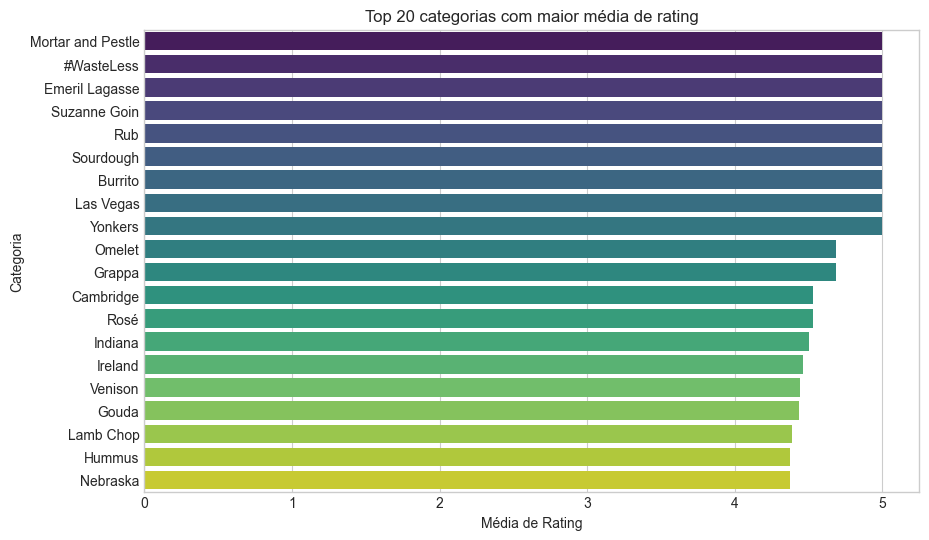

In [115]:
# Explodir categorias para analisar cada uma individualmente com rating
df_exploded = df_receitas.explode('categories')

# Calcular média de rating por categoria
rating_por_categoria = df_exploded.groupby('categories')['rating'].mean().sort_values(ascending=False).head(20)

# Plotar
plt.figure(figsize=(10, 6))
sns.barplot(x=rating_por_categoria.values, y=rating_por_categoria.index, palette="viridis")
plt.title('Top 20 categorias com maior média de rating')
plt.xlabel('Média de Rating')
plt.ylabel('Categoria')
plt.show()


In [116]:
# Explodir todas as listas de categorias para contar a frequência
todas_as_categorias = list(chain.from_iterable(df_receitas['categories']))
frequencia_categorias = pd.Series(Counter(todas_as_categorias)).sort_values(ascending=False)

# Criar um DataFrame com receita e uma categoria por linha
df_categorias = df_receitas[['rating', 'categories']].explode('categories')

# Filtrar apenas categorias com mais de 50 receitas
categorias_validas = frequencia_categorias[frequencia_categorias > 50].index
df_filtrado = df_categorias[df_categorias['categories'].isin(categorias_validas)]

# Calcular a média de rating por categoria
rating_por_categoria_filtrada = df_filtrado.groupby('categories')['rating'].mean().sort_values(ascending=False).head(20)


/var/folders/3f/by58trlj5m7185rxyjvklyg00000gn/T/ipykernel_9257/3230294060.py:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




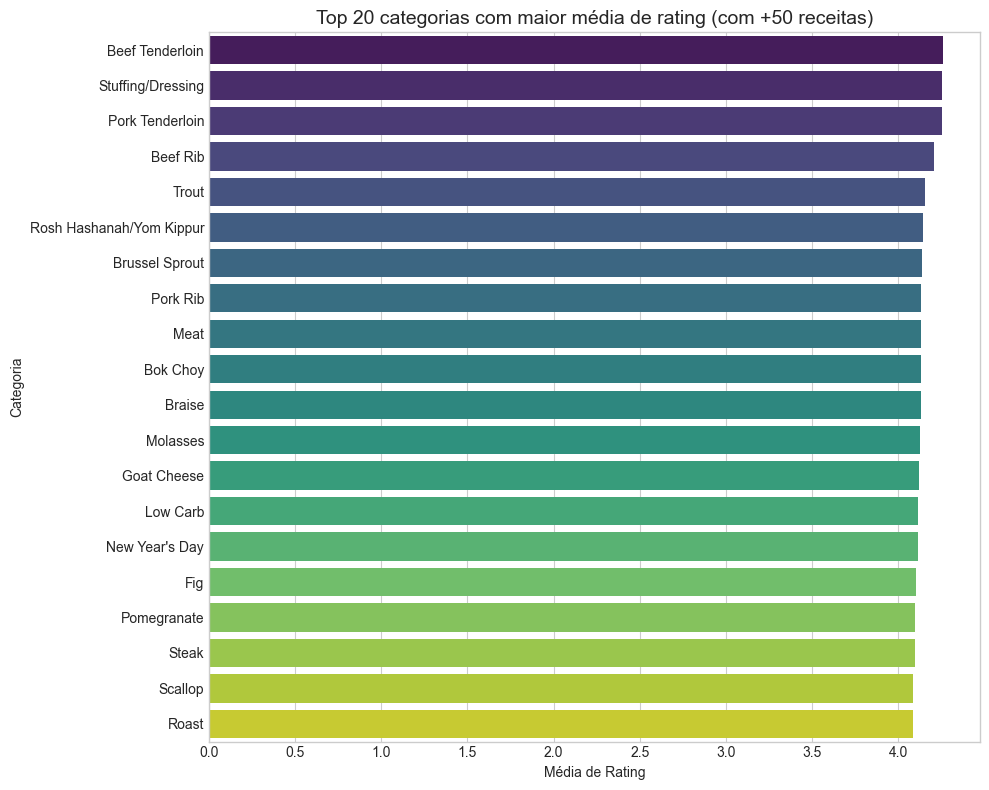

In [117]:
plt.figure(figsize=(10, 8))
sns.barplot(x=rating_por_categoria_filtrada.values, y=rating_por_categoria_filtrada.index, palette='viridis')
plt.title('Top 20 categorias com maior média de rating (com +50 receitas)', fontsize=14)
plt.xlabel('Média de Rating')
plt.ylabel('Categoria')
plt.tight_layout()
plt.show()


**Critério adotado:** considerar apenas categorias que aparecem em **mais de 50 receitas** no dataset.

**Justificativa:**  
Categorias com poucas ocorrências tendem a produzir **médias de rating instáveis** e com alta variância. Ao filtrar por frequência, garantimos que as médias sejam **estatisticamente mais confiáveis**, reduzindo o risco de insights enviesados por amostras pequenas.




###  Análise das Categorias com Maior Média de Avaliação

A partir do gráfico que exibe as **20 categorias com maior média de rating** (considerando apenas aquelas com pelo menos 50 receitas), é possível extrair **padrões valiosos** sobre os tipos de receitas mais bem avaliadas pelos usuários.

####  Ingredientes ou Perfil do Prato
Grande parte das categorias mais bem avaliadas está relacionada a **ingredientes específicos**, principalmente cortes de carne ou proteínas nobres:

- **Beef Tenderloin**, **Pork Tenderloin**, **Beef Rib**, **Pork Rib**, **Meat**, **Steak**, **Roast**, **Scallop**, **Goat Cheese**, **Trout**  
Essas categorias indicam que pratos com **proteínas valorizadas** e preparo mais elaborado tendem a receber melhores avaliações.

####  Estilo ou Método de Preparo
- **Stuffing/Dressing**, **Braise**  
São métodos de preparo ou acompanhamentos típicos de pratos principais, geralmente associados a ocasiões especiais. Podem transmitir uma ideia de **refeição caseira elaborada**, o que impacta positivamente a percepção do usuário.

####  Ocasiões Especiais / Culturais
- **Rosh Hashanah/Yom Kippur**, **New Year's Day**  
Categorias associadas a **datas comemorativas ou tradições religiosas** também aparecem entre as mais bem avaliadas. Isso pode indicar receitas mais **simbólicas, afetivas ou tradicionais**.

####  Vegetais e Frutas de Destaque
- **Brussel Sprout**, **Bok Choy**, **Pomegranate**, **Fig**  
Esses ingredientes, embora mais específicos, aparecem com alta avaliação. Isso sugere que receitas que **valorizam ingredientes menos comuns** ou de **perfil gourmet** também se destacam.

####  Estilo de dieta
- **Low Carb**  
A presença dessa categoria reforça a valorização por parte dos usuários de **dietas mais saudáveis ou controladas**, especialmente em receitas com apelo fitness ou funcional.

---

Esses achados indicam que as melhores avaliações não estão necessariamente nas receitas mais populares, mas sim naquelas que entregam **ingredientes valorizados**, **preparos diferenciados**, ou estão inseridas em **contextos culturais marcantes**.

Essa leitura pode servir de base para:

- Criar filtros para sistemas de recomendação;
- Identificar nichos de interesse (ex: receitas gourmet, ocasiões festivas);
- Explorar padrões entre tags e avaliação para insights de marketing ou curadoria de conteúdo.


### 8.2 Ingredientes mais comuns em receitas bem avaliadas

Selecionamos os ingredientes das receitas com nota acima de 4.0 para entender quais componentes aparecem com mais frequência em preparações bem avaliadas.

Isso nos ajuda a identificar padrões de preferência dos usuários — por exemplo: ingredientes básicos, saudáveis ou populares que aumentam a chance de uma receita agradar.

Essa análise pode embasar recomendações futuras ou servir como features para modelos preditivos.


In [118]:

# Considerar apenas receitas com nota maior ou igual a 4
df_bem_avaliadas = df_receitas[df_receitas['rating'] >= 4]

# Transformar todas as listas de ingredientes em uma única lista
ingredientes_flat = [ingrediente.strip().lower()
                     for lista in df_bem_avaliadas['ingredients'] if isinstance(lista, list)
                     for ingrediente in lista]

from collections import Counter

# Contar os ingredientes
contagem = Counter(ingredientes_flat)
ingredientes_comuns = contagem.most_common(20)  # top 20

# Criar DataFrame para plotar
df_top_ingredientes = pd.DataFrame(ingredientes_comuns, columns=['ingrediente', 'frequencia'])




/var/folders/3f/by58trlj5m7185rxyjvklyg00000gn/T/ipykernel_9257/3675373568.py:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




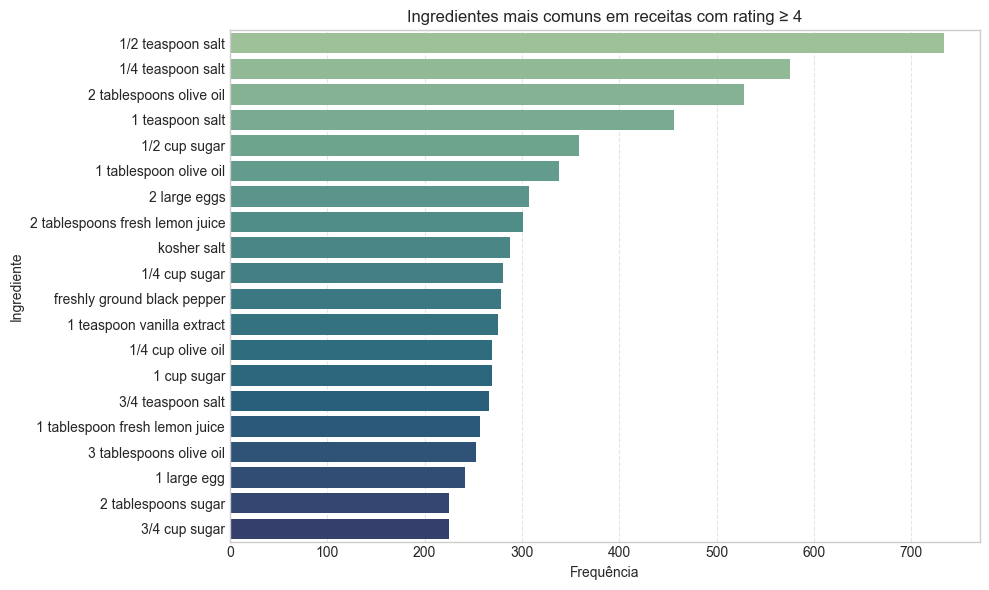

In [119]:
plt.figure(figsize=(10,6))
sns.barplot(data=df_top_ingredientes, y='ingrediente', x='frequencia', palette='crest')
plt.title('Ingredientes mais comuns em receitas com rating ≥ 4')
plt.xlabel('Frequência')
plt.ylabel('Ingrediente')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


### Ingredientes mais comuns em receitas com alta avaliação

Para entender os padrões por trás das receitas mais bem avaliadas, analisamos os ingredientes mais frequentes entre aquelas com rating **maior ou igual a 4**.

#### Principais descobertas:

- Ingredientes básicos como **sal**, **açúcar**, **ovos** e **azeite de oliva** aparecem com alta frequência, reforçando que receitas populares tendem a ser **simples, com elementos essenciais**.
- A presença de ingredientes como **vanilla extract**, **fresh lemon juice** e **black pepper** sugere que **pequenos toques de sabor** fazem diferença positiva na avaliação das receitas.
- Também é possível observar a predominância de **quantidades pequenas**, como "1/2 teaspoon", "1 tablespoon", o que reforça o equilíbrio nos temperos como fator valorizado.

Essa análise pode ser útil tanto para estratégias de recomendação quanto para identificar combinações de ingredientes com maior aceitação.


## Análise de valores ausentes

Antes de aprofundar a análise descritiva, avaliamos a presença de valores ausentes nas colunas do dataset.

As variáveis `fat`, `protein`, `sodium` e `calories` apresentam mais de 20% de dados ausentes, o que pode impactar negativamente a qualidade das análises estatísticas e modelagens preditivas. A coluna `desc` tem cerca de 33% ausentes, o que também pode limitar a aplicação de técnicas baseadas em texto.

Variáveis como `rating`, `date` e `title` apresentam valores ausentes residuais (< 0.2%), e colunas derivadas como `n_ingredientes`, `n_categories` e `n_directions` estão completas.

Vamos avaliar estratégias adequadas de tratamento para as colunas mais afetadas, como:
- **Remoção** de registros com ausência crítica em variáveis-chave;
- **Imputação** com média/mediana para variáveis numéricas (`sodium`, `fat`, etc.), caso sua distribuição permita;
- Ou **eliminação das variáveis** para análises específicas, se o impacto da ausência for muito alto.


In [120]:
# Lista das colunas numéricas com valores ausentes
colunas_para_preencher = ['calories', 'fat', 'protein', 'sodium']

# Preenchendo com a mediana de cada coluna
for col in colunas_para_preencher:
    mediana = df_receitas[col].median()
    df_receitas[col] = df_receitas[col].fillna(mediana)

# Confirmando que os valores ausentes foram tratados
df_receitas[colunas_para_preencher].isnull().sum()


calories    0
fat         0
protein     0
sodium      0
dtype: int64

### Relação entre proteínas e avaliação da receita

Receitas com maior teor de proteína tendem a apresentar notas um pouco superiores, embora a relação seja fraca. A linha de tendência indica uma leve correlação positiva, sugerindo que pratos mais ricos em proteína podem ser ligeiramente mais apreciados.

Esse tipo de relação pode ser útil, por exemplo, na recomendação de receitas voltadas ao público fitness ou em dietas específicas.


In [121]:
def analisar_outliers_iqr(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    limite_inf = Q1 - 1.5 * IQR
    limite_sup = Q3 + 1.5 * IQR
    outliers = df[(df[col] < limite_inf) | (df[col] > limite_sup)]
    
    print(f"\n Variável: {col}")
    print(f" - Q1: {Q1:.2f}")
    print(f" - Q3: {Q3:.2f}")
    print(f" - IQR: {IQR:.2f}")
    print(f" - Limite inferior: {limite_inf:.2f}")
    print(f" - Limite superior: {limite_sup:.2f}")
    print(f" - Total de outliers: {len(outliers)} ({len(outliers)/len(df)*100:.2f}%)")
    
    return outliers

# Aplicando a função para todas as variáveis
cols_nutri = ['calories', 'protein', 'fat', 'sodium']
outliers_dict = {col: analisar_outliers_iqr(df_receitas, col) for col in cols_nutri}



 Variável: calories
 - Q1: 229.00
 - Q3: 502.00
 - IQR: 273.00
 - Limite inferior: -180.50
 - Limite superior: 911.50
 - Total de outliers: 1707 (8.48%)

 Variável: protein
 - Q1: 4.00
 - Q3: 19.00
 - IQR: 15.00
 - Limite inferior: -18.50
 - Limite superior: 41.50
 - Total de outliers: 2351 (11.68%)

 Variável: fat
 - Q1: 10.00
 - Q3: 28.00
 - IQR: 18.00
 - Limite inferior: -17.00
 - Limite superior: 55.00
 - Total de outliers: 1826 (9.07%)

 Variável: sodium
 - Q1: 123.00
 - Q3: 570.00
 - IQR: 447.00
 - Limite inferior: -547.50
 - Limite superior: 1240.50
 - Total de outliers: 1911 (9.49%)


## Detecção de Outliers com IQR

A análise de outliers foi realizada nas variáveis nutricionais (`calories`, `protein`, `fat`, `sodium`) com base no método do IQR (Intervalo Interquartil). Foram considerados outliers os valores abaixo de Q1 - 1.5 * IQR ou acima de Q3 + 1.5 * IQR.

**Resumo dos Outliers Detectados:**

| Variável  | % Outliers | Limite Superior |
|-----------|------------|-----------------|
| Calories  | 8.48%      | 911.50          |
| Protein   | 11.68%     | 41.50           |
| Fat       | 9.07%      | 55.00           |
| Sodium    | 9.49%      | 1240.50         |

Apesar de estarem dentro de uma proporção controlável (menos de 12% em todos os casos), esses outliers podem impactar análises de correlação e visualizações. No entanto, **como os dados representam receitas reais e não erros claros (ex: valores negativos foram eliminados)**, optamos por **não remover os outliers neste momento**, a fim de preservar a representatividade da base.

> A depender da modelagem futura (como regressão ou clustering), esses valores podem ser tratados com técnicas como winsorization, transformação logarítmica ou normalização.


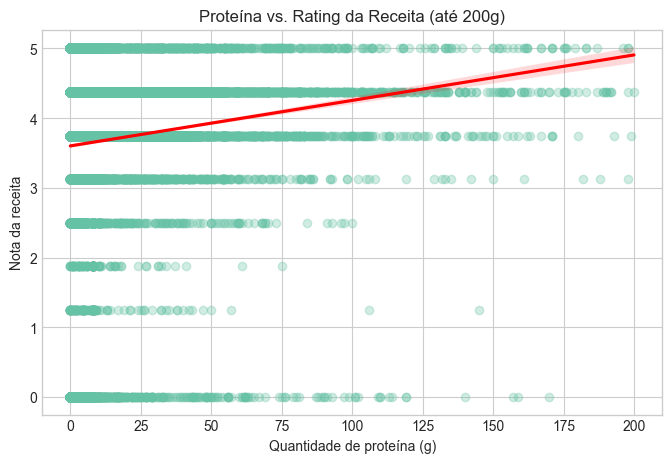

In [122]:
# Filtrando para proteínas <= 200g (faixa realista)
df_protein_filtrado = df_receitas[df_receitas['protein'] <= 200]

plt.figure(figsize=(8, 5))
sns.regplot(x='protein', y='rating', data=df_protein_filtrado, scatter_kws={'alpha':0.3}, line_kws={"color": "red"})
plt.title('Proteína vs. Rating da Receita (até 200g)')
plt.xlabel('Quantidade de proteína (g)')
plt.ylabel('Nota da receita')
plt.grid(True)
plt.show()



## Relação entre Proteína e Avaliação (Rating)

Após identificar que a variável `protein` possui **11.68% de outliers acima de 41.5g**, foi decidido restringir a análise visual para receitas com até **200g de proteína**, a fim de reduzir a distorção causada por valores extremos e melhorar a legibilidade do gráfico.

O gráfico de dispersão com linha de tendência mostra uma **leve relação positiva entre proteína e nota da receita**, sugerindo que receitas com maior teor proteico tendem a receber avaliações um pouco melhores dos usuários.

> Valores muito elevados podem ainda representar erros ou casos raros, mas como não há valores negativos e a maioria dos pontos está abaixo desse limite, optamos por apenas **filtrar na visualização** ao invés de excluir os dados.


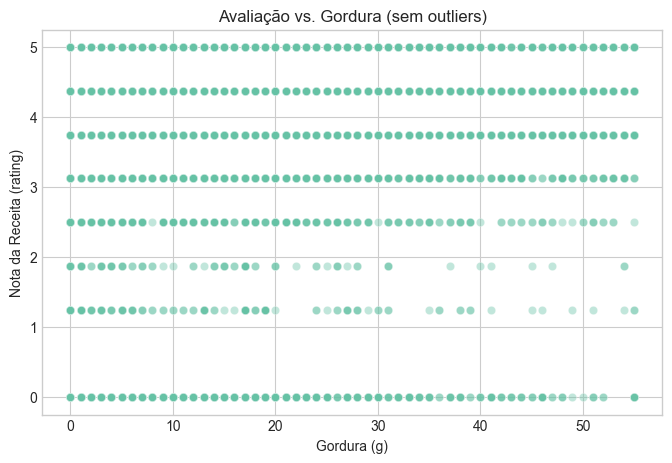

In [123]:
# Limite superior para gordura com base no IQR já calculado
limite_fat = 55  

# Filtrar dados sem outliers
df_fat_filtrado = df_receitas[df_receitas['fat'] <= limite_fat]

# Scatterplot sem outliers de gordura
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df_fat_filtrado, x='fat', y='rating', alpha=0.4)
plt.title('Avaliação vs. Gordura (sem outliers)')
plt.xlabel('Gordura (g)')
plt.ylabel('Nota da Receita (rating)')
plt.grid(True)
plt.show()



### Análise: Sódio vs. Calorias (sem outliers)

O gráfico acima mostra a relação entre a quantidade de sódio e as calorias das receitas, **considerando apenas valores dentro do intervalo interquartil (sem outliers)**.

- A linha vermelha representa a tendência geral (regressão linear), que indica uma **relação positiva** entre sódio e calorias — ou seja, receitas com mais sódio **tendem** a ter mais calorias.
- No entanto, a **dispersão dos pontos é alta**, o que revela que essa relação **não é forte**. Para uma mesma quantidade de sódio, há receitas com variações significativas de calorias.
- Isso sugere que **outros fatores além do sódio** influenciam as calorias totais de uma receita, como o teor de gordura, carboidratos ou o tipo de ingrediente utilizado.

A versão anterior do gráfico, que incluía outliers, mostrava uma relação exageradamente forte, **mas distorcida por valores extremos** (ex: milhões de mg de sódio/calorias). Após a remoção desses outliers, conseguimos visualizar a tendência real de forma mais precisa e realista.

**Conclusão:** Existe uma leve tendência entre sódio e calorias, mas ela é fraca. Essa análise reforça a importância de tratar os outliers antes de interpretar relações em variáveis contínuas.



### Avaliação vs. Número de Etapas

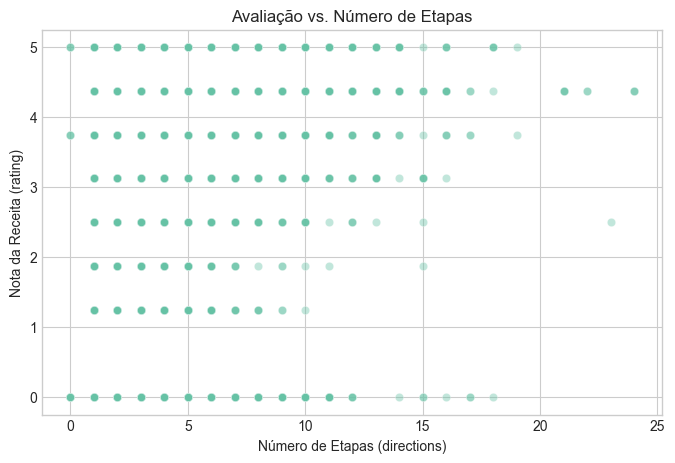

In [124]:
# Gráfico de dispersão entre número de etapas e avaliação
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df_receitas, x='n_directions', y='rating', alpha=0.4)
plt.title('Avaliação vs. Número de Etapas')
plt.xlabel('Número de Etapas (directions)')
plt.ylabel('Nota da Receita (rating)')
plt.grid(True)
plt.show()


##  Respostas às Perguntas Exploratórias

### 1. Quais são as categorias (tags) mais comuns entre as receitas?
Realizamos a contagem das tags presentes na variável `categories` apenas entre receitas com **notas altas (rating ≥ 4)**. Os grupos mais frequentes foram:

- **Tipo de comida**: `Dessert`, `Main Dish`, `Appetizer`
- **Estilo de preparo**: `Quick & Easy`, `Gourmet`
- **Ingredientes e perfis**: `Fruit`, `Onion`, `Chocolate`
- **Público/ocasião**: `Kid-Friendly`, `Thanksgiving`, `Dinner Party`
- **Restrições alimentares**: `Gluten-Free`, `Vegan`
- **Região/chef**: `Las Vegas`, `Emeril Lagasse`

> O objetivo foi entender **o que mais aparece entre receitas bem avaliadas**, e não no total geral. Filtramos categorias com pelo menos **50 ocorrências**, para evitar distorções.

---

### 2. Receitas com nota alta têm mais proteínas ou menos gordura?
- **Proteína**: Existe uma **tendência positiva** entre a quantidade de proteína e a nota. Receitas com maior teor proteico tendem a ter avaliações mais altas. Isso foi evidenciado tanto no scatterplot (após remover outliers) quanto nos boxplots.
- **Gordura**: Não foi identificada uma relação clara. A dispersão é grande e não há variação significativa das medianas entre os ratings. Ou seja, **a gordura não parece influenciar diretamente a avaliação**.

---

### 3. Quais são os ingredientes mais usados nas receitas com nota alta?
Após analisar as receitas com `rating ≥ 4`, extraímos os ingredientes mais citados. Os principais incluem:

- `salt`, `sugar`, `onion`, `butter`, `garlic`, `milk`, `flour`, `egg`

> Isso sugere o uso frequente de ingredientes básicos, que são comuns em diversos tipos de preparo e aparecem amplamente nas receitas mais bem avaliadas.

---

### 4. Receitas com muitas etapas (directions) tendem a ter menor nota?
Não. Ao relacionar o número de etapas (`n_directions`) com o rating, **não observamos uma tendência clara de queda**. Há receitas com **muitas ou poucas etapas** em todas as faixas de avaliação. A complexidade do preparo não parece influenciar diretamente a nota.

---

### 5. Quais colunas têm mais dados ausentes e como tratar isso?

| Coluna     | Ausentes (%) |
|------------|--------------|
| `desc`     | 32.96%       |
| `fat`      | 20.97%       |
| `protein`  | 20.87%       |
| `sodium`   | 20.65%       |
| `calories` | 20.64%       |
| `rating`   | 0.15%        |

- As variáveis `desc` e as nutricionais tinham valores faltantes.
- Como estávamos usando essas variáveis para análises com `rating`, **optamos por usar `dropna()` antes dos gráficos**, evitando viés ou distorções sem necessidade de imputação.
- As demais colunas importantes (`ingredients`, `categories`, `directions`) **não tinham dados ausentes**.

---

In [125]:
os.makedirs('../data/processed', exist_ok=True)
df_receitas.to_csv('../data/processed/receitas_tratadas.csv', index=False)
